# Game Outcome Model

This notebook will test a number of classifier and logistic regression models to predict game outcome.

Models Include:
- Logistic Regression
- Decision Tree
- Random Forest

## Load Libraries

In [214]:
import os
import sys
import warnings

import IPython
import ipywidgets as widgets
import matplotlib.pyplot as plt
import seaborn as sns
import mglearn
import numpy as np
import pandas as pd
from IPython.display import HTML, display
from ipywidgets import interact, interactive
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, BernoulliNB
import xgboost as xgb
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from utils import *
from sklearn.model_selection import GridSearchCV
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler

import random

import yellowbrick
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.decomposition import NMF, PCA

%matplotlib inline
pd.set_option("display.max_colwidth", 200)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Set Folder Path

In [215]:
# Navigate two folders up
#os.chdir(os.path.join(os.getcwd(), ".."))

os.chdir("/Users/dusty/Desktop/projects/sports_analytics.nosync/fantasy_wizard/")

# Print the new working directory
print("Working In:", os.getcwd())

Working In: /Users/dusty/Desktop/projects/sports_analytics.nosync/fantasy_wizard


## Load Data

In [221]:
# Load rb data
game_data = pd.read_csv(os.path.join(os.getcwd(), "data", "processed", "games", "modeling_game_data.csv"))

## Investigate Data

In [222]:
game_data.shape

(1707, 86)

In [223]:
game_data.sort_values(by='game_id').head()

,game_id,season,week,team,game_type,home_away,stadium_id,weekday,game_window,qb,coach,opposing_qb,opposing_coach,apy_cap_pct,years_left,home_rest,away_rest,div_game,roof,temp_conditions,wind_conditions,spread_line,points_scored,points_allowed,favored,score,result,rolling_win_pct,rolling_off_ppg,rolling_off_pypg,rolling_off_rypg,rolling_off_typg,rolling_off_ptdpg,rolling_off_rtdpg,rolling_off_ttdpg,rolling_def_ppg,rolling_def_pypg,rolling_def_rypg,rolling_def_typg,rolling_def_ptdpg,rolling_def_rtdpg,rolling_def_ttdpg,rolling_avg_time_to_throw,rolling_avg_completed_air_yards,rolling_avg_intended_air_yards,rolling_avg_air_yards_differential,rolling_avg_attempts,rolling_avg_pass_yards,rolling_avg_pass_touchdowns,rolling_avg_interceptions,rolling_avg_passer_rating,rolling_avg_completions,rolling_avg_completion_percentage,rolling_avg_expected_completion_percentage,rolling_avg_completion_percentage_above_expectation,rolling_avg_avg_air_distance,rolling_avg_max_air_distance,rolling_n_on_report,rolling_n_on_practice_report,prev_season_win_pct,prev_season_off_ppg,prev_season_off_plays_per_game,prev_season_off_run_pct,prev_season_off_pass_pct,prev_season_off_pypg,prev_season_off_rypg,prev_season_off_typg,prev_season_off_ptdpg,prev_season_off_rtdpg,prev_season_off_ttdpg,prev_season_off_fdpg,prev_season_off_spg,prev_season_off_ipg,prev_season_def_ppg,prev_season_def_plays_per_game,prev_season_def_run_pct,prev_season_def_pass_pct,prev_season_def_pypg,prev_season_def_rypg,prev_season_def_typg,prev_season_def_ptdpg,prev_season_def_rtdpg,prev_season_def_ttdpg,prev_season_def_fdpg,prev_season_def_spg,prev_season_def_ipg
0,2016_01_BUF_BAL,2016,1,BUF,REG,away,BAL00,Sunday,morning,Tyrod Taylor,Rex Ryan,Tyrod Taylor,Rex Ryan,0.008,1,medium,medium,0,outdoors,hot,low,3.0,7,13,0,7.0,0,0.50,20.75,206.50,187.0,393.50,0.75,1.50,2.25,20.25,226.00,121.75,347.75,1.75,0.50,2.25,2.809450,5.801429,7.780500,-1.979071,21.000000,130.000000,1.000000,1.000000,79.464286,14.000000,66.666667,70.472177,-3.805511,20.150144,39.153066,1,1,0.500000,23.687500,62.687500,0.502667,0.497333,208.937500,153.500000,362.437500,1.437500,1.187500,2.625000,17.437500,2.625000,2.625000,22.437500,62.625000,0.380593,0.619407,248.500000,109.687500,358.187500,1.875000,0.625000,2.500000,18.187500,1.312500,1.312500
3,2016_01_CAR_DEN,2016,1,DEN,REG,home,DEN00,Thursday,evening,Trevor Siemian,Gary Kubiak,Cam Newton,Ron Rivera,0.004,2,medium,medium,0,outdoors,hot,high,-3.0,21,20,0,21.0,1,1.00,23.50,190.25,128.0,318.25,0.75,1.00,1.75,16.00,251.75,89.50,341.25,0.75,0.75,1.50,2.780415,6.343064,7.493870,-1.150807,35.333333,292.333333,2.666667,0.666667,111.957592,25.666667,72.344055,64.941059,7.402995,20.253075,48.172752,0,0,0.789474,22.210526,65.210526,0.397262,0.602738,233.578947,106.684211,340.263158,1.105263,0.789474,1.894737,17.210526,2.526316,2.526316,17.894737,64.842105,0.374542,0.625458,210.157895,84.157895,294.315789,1.052632,0.684211,1.736842,15.789474,3.473684,3.473684
1,2016_01_CHI_HOU,2016,1,CHI,REG,away,HOU00,Sunday,morning,Jay Cutler,John Fox,Jay Cutler,John Fox,0.136,4,medium,medium,0,closed,indoor,indoor,5.5,14,23,0,14.0,0,0.25,21.00,218.25,116.5,334.75,1.75,0.50,2.25,26.75,265.75,101.25,367.00,2.50,1.00,3.50,2.772146,4.708846,7.949409,-3.240563,28.666667,172.666667,0.666667,0.333333,79.282407,17.666667,61.458333,64.851220,-3.392886,22.886974,45.336766,0,1,0.375000,20.937500,63.875000,0.455739,0.544261,228.875000,116.375000,345.250000,1.312500,0.812500,2.125000,17.937500,2.125000,2.125000,24.812500,60.437500,0.438360,0.561640,224.562500,121.625000,346.187500,1.937500,0.562500,2.500000,17.937500,2.187500,2.187500
8,2016_01_CIN_NYJ,2016,1,NYJ,REG,home,NYC01,Sunday,morning,Ryan Fitzpatrick,Todd Bowles,Andy Dalton,Marvin Lewis,0.077,1,medium,medium,0,outdoors,medium,high,1.0,22,23,1,22.0,0,0.75,23.00,254.50,130.5,385.00,2.25,0.25,2.50,16.50,211.75,83.75,295.50,0.75,0.50,1.25,3.116875,3.142222,5.213731,-2.071509,24.000000,176.000000,0.500000,0.500000,80.664062,16.000000,64.062500,64.693368

### Numeric Variable Selection

In [224]:
numeric_vars = []

varset_1 = [26] + list(range(1, 20))
#sns.pairplot(game_data.iloc[:,varset_1], hue='result')    

In [225]:
numeric_vars = numeric_vars + ['season', 'apy_cap_pct', 'years_left']

In [226]:
varset_2 = list(set([26] + list(range(21, 30))))
#sns.pairplot(game_data.iloc[:,varset_2], hue='result')   

In [227]:
numeric_vars = numeric_vars + ['favored', 'rolling_win_pct', 'rolling_off_ppg', 'rolling_off_pypg']

In [228]:
varset_3 = [26] + list(range(31, 40))
#sns.pairplot(game_data.iloc[:,varset_3], hue='result')   

In [229]:
numeric_vars = numeric_vars + ['roll_off_typg', 'rolling_off_ptdpg', 'rolling_off_rtdpg', 'rolling_off_ttdpg', 'rolling_def_rypg']

In [230]:
varset_4 = [26] + list(range(41, 50))
#sns.pairplot(game_data.iloc[:,varset_4], hue='result')   

In [231]:
numeric_vars = numeric_vars + ['rolling_def_ttdpg', 'rolling_avg_air_yards_differential','rolling_avg_attempts', 'rolling_avg_pass_yards', 'rolling_avg_pass_touchdowns', 'rolling_avg_interceptions']

In [232]:
varset_5 = [26] + list(range(51, 60))
#sns.pairplot(game_data.iloc[:,varset_5], hue='result')   

In [233]:
numeric_vars = numeric_vars + ['prev_season_win_pct']

In [234]:
varset_6 = [26] + list(range(61, 70))
#sns.pairplot(game_data.iloc[:,varset_6], hue='result')   

In [235]:
numeric_vars = numeric_vars + ['prev_season_off_plays_per_game', 'prev_season_off_run_pct', 'prev_season_off_pass_pct', 'prev_season_off_pypg', 'prev_season_off_rypg',
                               'prev_season_off_typg', 'prev_season_off_ptdpg', 'prev_season_off_rtdpg', 'prev_season_off_ttdpg']

In [236]:
varset_7 = [26] + list(range(71, 86))
#sns.pairplot(game_data.iloc[:,varset_7], hue='result')   

In [237]:
numeric_vars = numeric_vars + ['prev_season_off_spg', 'prev_season_off_ipg', 'prev_season_def_ppg', 'prev_season_def_plays_per_game',
                               'prev_season_def_pypg', 'prev_season_def_typg', 'prev_season_def_spg', 'prev_season_def_ipg']

In [238]:
print("Numeric Variables that show variation by game outcome: ", numeric_vars)

Numeric Variables that show variation by game outcome:  ['season', 'apy_cap_pct', 'years_left', 'favored', 'rolling_win_pct', 'rolling_off_ppg', 'rolling_off_pypg', 'roll_off_typg', 'rolling_off_ptdpg', 'rolling_off_rtdpg', 'rolling_off_ttdpg', 'rolling_def_rypg', 'rolling_def_ttdpg', 'rolling_avg_air_yards_differential', 'rolling_avg_attempts', 'rolling_avg_pass_yards', 'rolling_avg_pass_touchdowns', 'rolling_avg_interceptions', 'prev_season_win_pct', 'prev_season_off_plays_per_game', 'prev_season_off_run_pct', 'prev_season_off_pass_pct', 'prev_season_off_pypg', 'prev_season_off_rypg', 'prev_season_off_typg', 'prev_season_off_ptdpg', 'prev_season_off_rtdpg', 'prev_season_off_ttdpg', 'prev_season_off_spg', 'prev_season_off_ipg', 'prev_season_def_ppg', 'prev_season_def_plays_per_game', 'prev_season_def_pypg', 'prev_season_def_typg', 'prev_season_def_spg', 'prev_season_def_ipg']


### Categorical Variable Selection

In [239]:
game_data.head()

,game_id,season,week,team,game_type,home_away,stadium_id,weekday,game_window,qb,coach,opposing_qb,opposing_coach,apy_cap_pct,years_left,home_rest,away_rest,div_game,roof,temp_conditions,wind_conditions,spread_line,points_scored,points_allowed,favored,score,result,rolling_win_pct,rolling_off_ppg,rolling_off_pypg,rolling_off_rypg,rolling_off_typg,rolling_off_ptdpg,rolling_off_rtdpg,rolling_off_ttdpg,rolling_def_ppg,rolling_def_pypg,rolling_def_rypg,rolling_def_typg,rolling_def_ptdpg,rolling_def_rtdpg,rolling_def_ttdpg,rolling_avg_time_to_throw,rolling_avg_completed_air_yards,rolling_avg_intended_air_yards,rolling_avg_air_yards_differential,rolling_avg_attempts,rolling_avg_pass_yards,rolling_avg_pass_touchdowns,rolling_avg_interceptions,rolling_avg_passer_rating,rolling_avg_completions,rolling_avg_completion_percentage,rolling_avg_expected_completion_percentage,rolling_avg_completion_percentage_above_expectation,rolling_avg_avg_air_distance,rolling_avg_max_air_distance,rolling_n_on_report,rolling_n_on_practice_report,prev_season_win_pct,prev_season_off_ppg,prev_season_off_plays_per_game,prev_season_off_run_pct,prev_season_off_pass_pct,prev_season_off_pypg,prev_season_off_rypg,prev_season_off_typg,prev_season_off_ptdpg,prev_season_off_rtdpg,prev_season_off_ttdpg,prev_season_off_fdpg,prev_season_off_spg,prev_season_off_ipg,prev_season_def_ppg,prev_season_def_plays_per_game,prev_season_def_run_pct,prev_season_def_pass_pct,prev_season_def_pypg,prev_season_def_rypg,prev_season_def_typg,prev_season_def_ptdpg,prev_season_def_rtdpg,prev_season_def_ttdpg,prev_season_def_fdpg,prev_season_def_spg,prev_season_def_ipg
0,2016_01_BUF_BAL,2016,1,BUF,REG,away,BAL00,Sunday,morning,Tyrod Taylor,Rex Ryan,Tyrod Taylor,Rex Ryan,0.008,1,medium,medium,0,outdoors,hot,low,3.0,7,13,0,7.0,0,0.50,20.75,206.50,187.0,393.50,0.75,1.50,2.25,20.25,226.00,121.75,347.75,1.75,0.50,2.25,2.809450,5.801429,7.780500,-1.979071,21.000000,130.000000,1.000000,1.000000,79.464286,14.000000,66.666667,70.472177,-3.805511,20.150144,39.153066,1,1,0.500000,23.687500,62.687500,0.502667,0.497333,208.937500,153.500000,362.437500,1.437500,1.187500,2.625000,17.437500,2.625000,2.625000,22.437500,62.625000,0.380593,0.619407,248.500000,109.687500,358.187500,1.875000,0.625000,2.500000,18.187500,1.312500,1.312500
1,2016_01_CHI_HOU,2016,1,CHI,REG,away,HOU00,Sunday,morning,Jay Cutler,John Fox,Jay Cutler,John Fox,0.136,4,medium,medium,0,closed,indoor,indoor,5.5,14,23,0,14.0,0,0.25,21.00,218.25,116.5,334.75,1.75,0.50,2.25,26.75,265.75,101.25,367.00,2.50,1.00,3.50,2.772146,4.708846,7.949409,-3.240563,28.666667,172.666667,0.666667,0.333333,79.282407,17.666667,61.458333,64.851220,-3.392886,22.886974,45.336766,0,1,0.375000,20.937500,63.875000,0.455739,0.544261,228.875000,116.375000,345.250000,1.312500,0.812500,2.125000,17.937500,2.125000,2.125000,24.812500,60.437500,0.438360,0.561640,224.562500,121.625000,346.187500,1.937500,0.562500,2.500000,17.937500,2.187500,2.187500
2,2016_01_NYG_DAL,2016,1,DAL,REG,home,DAL00,Sunday,afternoon,Dak Prescott,Jason Garrett,Eli Manning,Ben McAdoo,0.004,3,medium,medium,1,closed,indoor,indoor,1.0,19,20,1,19.0,0,0.00,13.00,218.25,131.5,349.75,1.00,0.25,1.25,24.25,241.75,173.75,415.50,1.75,1.25,3.00,3.083636,7.924951,8.654680,-0.729729,35.500000,338.500000,3.000000,1.500000,108.661741,23.000000,64.901478,64.761478,0.140000,22.827616,46.845133,0,3,0.250000,17.187500,60.000000,0.416166,0.583834,217.062500,118.625000,335.687500,1.000000,0.500000,1.500000,17.187500,2.062500,2.062500,23.375000,61.187500,0.446905,0.553095,227.125000,122.187500,349.312500,1.187500,1.000000,2.187500,18.125000,1.937500,1.937500
3,2016_01_CAR_DEN,2016,1,DEN,REG,home,DEN00,Thursday,evening,Trevor Siemian,Gary Kubiak,Cam Newton,Ron Rivera,0.004,2,medium,medium,0,outdoors,hot,high,-3.0,21,20,0,21.0,1,1.00,23.50,190.25,128.0,318.25,0.75,1.00,1.75,16.00,251.75,89.50,341.25,0.75,0.75,1.50,2.780415,6.343064,7.493870,-1.150807,35.333333,292.333333,2.666667,0.666667,111.957592,25.666667,72.344055,64.94105

## Split into Train, Test, Validation Sets
- 80-20 split
- Validation year will be 2023

In [240]:
# Get Target Columns
target_columns = ['result']

# Separate validation data
validation_season = game_data[game_data['season'] == 2023]
validation_season_x = validation_season.drop(columns=target_columns)
validation_season_y = validation_season.result

# Remove validation season
modeling_seasons = game_data[game_data['season'] != 2023]

# Separate Modeling Data
modeling_data_x = modeling_seasons.drop(columns=target_columns)
modeling_data_y = modeling_seasons.result

# Split into Train and Test
X_train, X_test, y_train, y_test = train_test_split(
    modeling_data_x, modeling_data_y, train_size=0.8, test_size=0.1, random_state=42
)

modeling_data_span = sorted(set(modeling_data_x.season))
validation_data_span = sorted(set(validation_season_x.season))

print("Modeling Seasons: ", modeling_data_span)
print("Validation Seasons: ", validation_data_span)

Modeling Seasons:  [2016, 2017, 2018, 2019, 2020, 2021, 2022]
Validation Seasons:  [2023]


In [241]:
print(f"Training Data Dimensions: {X_train.shape}")
print(f"Test Data Dimensions: {X_test.shape}")

assert(X_train.shape[0] == y_train.shape[0])
assert(X_test.shape[0] == y_test.shape[0])

Training Data Dimensions: (1218, 85)
Test Data Dimensions: (153, 85)


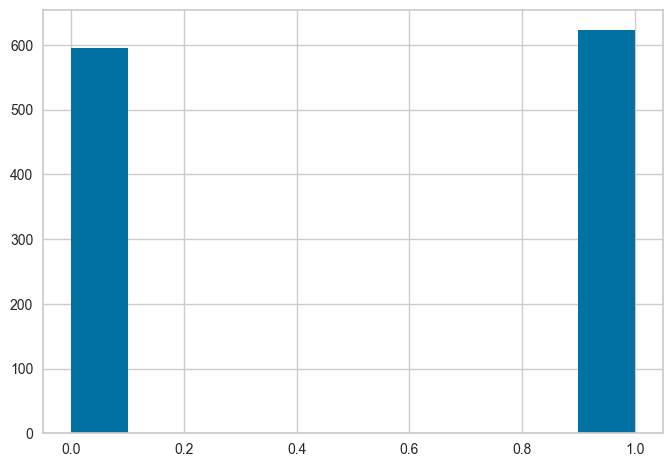

In [242]:
plt.hist(y_train);

## Define Columns for Modeling

In [243]:
modeling_columns = ['apy_cap_pct', 'years_left', 'spread_line',
                   'rolling_win_pct', 'rolling_off_ppg', 'rolling_off_pypg',
                   'rolling_off_rypg', 'rolling_off_typg', 'rolling_off_ptdpg',
                   'rolling_off_rtdpg', 'rolling_off_ttdpg', 'rolling_def_ppg',
                   'rolling_def_pypg', 'rolling_def_rypg', 'rolling_def_typg',
                   'rolling_def_ptdpg', 'rolling_def_rtdpg', 'rolling_def_ttdpg',
                   'rolling_avg_time_to_throw', 'rolling_avg_completed_air_yards',
                   'rolling_avg_intended_air_yards', 'rolling_avg_air_yards_differential',
                   'rolling_avg_attempts', 'rolling_avg_pass_yards',
                   'rolling_avg_pass_touchdowns', 'rolling_avg_interceptions',
                   'rolling_avg_passer_rating', 'rolling_avg_completions',
                   'rolling_avg_completion_percentage',
                   'rolling_avg_expected_completion_percentage',
                   'rolling_avg_completion_percentage_above_expectation',
                   'rolling_avg_avg_air_distance', 'rolling_avg_max_air_distance',
                   'rolling_n_on_report', 'rolling_n_on_practice_report',
                   'prev_season_win_pct', 'prev_season_off_ppg',
                   'prev_season_off_plays_per_game', 'prev_season_off_run_pct',
                   'prev_season_off_pass_pct', 'prev_season_off_pypg',
                   'prev_season_off_rypg', 'prev_season_off_typg', 'prev_season_off_ptdpg',
                   'prev_season_off_rtdpg', 'prev_season_off_ttdpg',
                   'prev_season_off_fdpg', 'prev_season_off_spg', 'prev_season_off_ipg',
                   'prev_season_def_ppg', 'prev_season_def_plays_per_game',
                   'prev_season_def_run_pct', 'prev_season_def_pass_pct',
                   'prev_season_def_pypg', 'prev_season_def_rypg', 'prev_season_def_typg',
                   'prev_season_def_ptdpg', 'prev_season_def_rtdpg',
                   'prev_season_def_ttdpg', 'prev_season_def_fdpg', 'prev_season_def_spg',
                   'prev_season_def_ipg']

drop_columns = ['game_id', 'team', 'points_scored', 'points_allowed', 'score']

# Get cat columns
cat_columns = ['season', 'week', 'game_type', 'home_away',
               'stadium_id', 'weekday', 'game_window', 'qb', 'coach', 'opposing_qb',
               'opposing_coach', 'home_rest', 'away_rest',
               'div_game', 'roof', 'temp_conditions', 'wind_conditions', 'favored']

# Get numeric columns
non_numeric_columns = drop_columns + cat_columns
numeric_columns = X_train.drop(columns=non_numeric_columns).columns

assert(len(numeric_columns) + len(drop_columns) + len(cat_columns) == len(X_train.columns))

In [244]:
# Preprocess Data

# Impute missing data
#imputer = SimpleImputer(strategy="median")
#PCA_data = imputer.fit_transform(modeling_data[numeric_columns])
PCA_data = modeling_data_x[numeric_columns].dropna()

# Create scaling object
scaler = MinMaxScaler()

# Fit scaling object
scaler.fit(modeling_data_x[numeric_columns].dropna())

# Create transformed data
scaled_modeling_data = pd.DataFrame(scaler.transform(modeling_data_x[numeric_columns].dropna()), columns=numeric_columns)

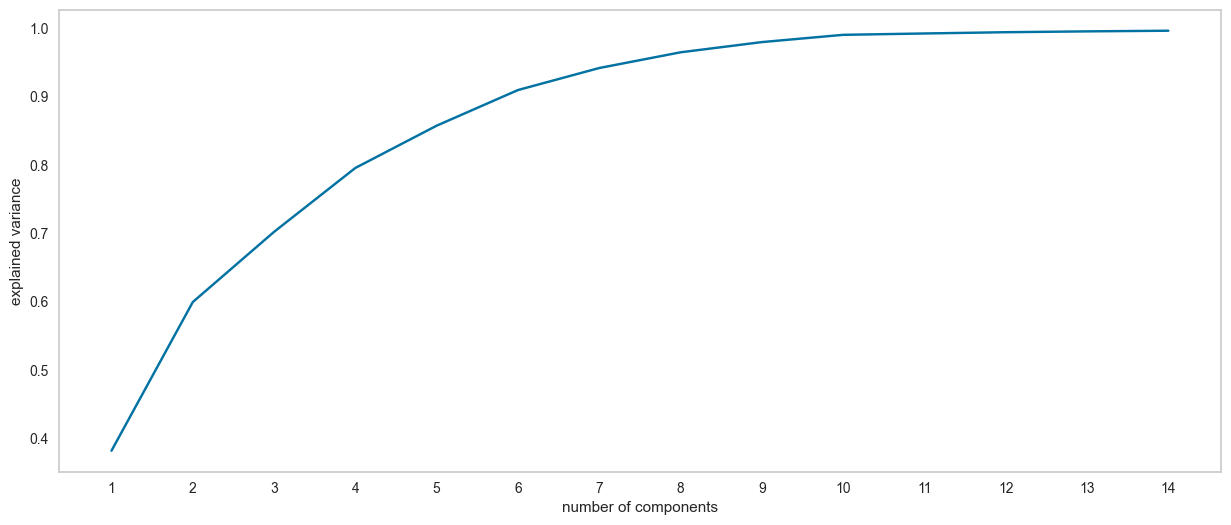

In [245]:
# Creating and fitting the model
pca = PCA(n_components=14, random_state=42).fit(PCA_data)

plt.figure(figsize=(15, 6))
plt.plot(range(1, 15), np.cumsum(pca.explained_variance_ratio_))
plt.xticks(range(1, 15))
plt.xlabel("number of components")
plt.ylabel("explained variance")
plt.grid();

In [247]:
np.cumsum(pca.explained_variance_ratio_)

array([0.38189336, 0.59947133, 0.70222879, 0.79573224, 0.85758811,
       0.90971971, 0.94197075, 0.96494837, 0.97990042, 0.99052372,
       0.99251354, 0.99435745, 0.99558813, 0.99653854])

In [248]:
pca.explained_variance_ratio_.sum()

0.996538541740169

### Summary

*Eight* PCA components explain ~96% of the explained variance in the data, so I will use 8 PCs in this analysis

In [249]:
n_pc = 8

### Define Pipeline

In [250]:
numeric_transformer = make_pipeline(SimpleImputer(strategy="median"), 
                                    StandardScaler())

categorical_transformer = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    OneHotEncoder(handle_unknown="ignore", sparse_output=False),
)

preprocessor = make_column_transformer(
    ("drop", drop_columns),
    (numeric_transformer, numeric_columns),
    (categorical_transformer, cat_columns),
)

In [251]:
# Define Default Pipelines
pipe_logistic = make_pipeline(preprocessor, 
                              PCA(n_components=n_pc), 
                              LogisticRegression())
pipe_decision_tree = make_pipeline(preprocessor, 
                                   PCA(n_components=n_pc), 
                                   DecisionTreeClassifier())
pipe_random_forest = make_pipeline(preprocessor, 
                                   PCA(n_components=n_pc), 
                                   RandomForestClassifier())
pipe_naive_bayes = make_pipeline(preprocessor, 
                                 PCA(n_components=n_pc), 
                                 BernoulliNB())
pipe_xgboost = make_pipeline(preprocessor, 
                             PCA(n_components=n_pc), 
                             xgb.XGBClassifier())

# Define Parameter Grids
logistic_param_grid = {
    'regressor__C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization parameter
    'regressor__penalty': ['l1', 'l2'],               # Penalty norm
    'regressor__solver': ['liblinear', 'saga']        # Algorithm for optimization
}

# Define Parameter Grids for Decision Tree
decision_tree_param_grid = {
    'classifier__max_depth': [None, 5, 10, 15],         # Maximum depth of the tree
    'classifier__min_samples_split': [2, 5, 10],        # Minimum samples required to split a node
    'classifier__min_samples_leaf': [1, 2, 4],          # Minimum samples required at each leaf node
    'classifier__max_features': ['sqrt', 'log2'] # Number of features to consider when looking for the best split
}

# Define Parameter Grids for Random Forest
random_forest_param_grid = {
    'classifier__n_estimators': [100, 200, 300],     # Number of trees in the forest
    'classifier__max_depth': [None, 5, 10, 15],       # Maximum depth of the tree
    'classifier__min_samples_split': [2, 5, 10],      # Minimum samples required to split a node
    'classifier__min_samples_leaf': [1, 2, 4],        # Minimum samples required at each leaf node
    'classifier__max_features': ['sqrt', 'log2'] # Number of features to consider when looking for the best split
}

naive_bayes_param_grid = {
    'classifier__alpha': [0.1, 0.5, 1.0],           # Smoothing parameter
    'classifier__binarize': [0.0, 0.1, 0.5],        # Threshold for binarizing features
    'classifier__fit_prior': [True, False],         # Whether to learn class prior probabilities
    'classifier__class_prior': [None, [0.3, 0.7]]   # Prior probabilities of the classes
}

# Define Parameter Grids for XGBoost
xgboost_param_grid = {
    'classifier__learning_rate': [0.01, 0.1, 0.2],             # Boosting learning rate
    'classifier__max_depth': [3, 5, 7],                        # Maximum depth of a tree
    'classifier__n_estimators': [100, 200, 300],               # Number of boosting rounds
    'classifier__gamma': [0, 0.1, 0.2],                        # Minimum loss reduction required to make a further partition on a leaf node of the tree
    'classifier__subsample': [0.8, 0.9, 1.0],                  # Subsample ratio of the training instances
    'classifier__colsample_bytree': [0.8, 0.9, 1.0]            # Subsample ratio of columns when constructing each tree
}

## Model 1: Logistic Regression

In [252]:
# Create tmp pipeline
opt_pipeline = Pipeline([('preprocessor', preprocessor),
                         ('pca', pipe_logistic['pca']),
                         ('regressor', pipe_logistic['logisticregression'])])

# Create the GridSearchCV object
grid_search_logistic = GridSearchCV(opt_pipeline, logistic_param_grid, cv=5, n_jobs=-1, verbose=1)

# Fit the GridSearchCV object to the data
grid_search_logistic.fit(X_train, y_train)

# Print the best parameters and the best score
print("Best parameters: ", grid_search_logistic.best_params_)
print("Best score: ", grid_search_logistic.best_score_)

# Define Winning Model
#params_logistic = grid_search_logistic.best_params_
#params_logistic = {'regressor__C': 0.1, 
#                   'regressor__penalty': 'l1', 
#                   'regressor__solver': 'liblinear'}
#print(params_logistic)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters:  {'regressor__C': 0.001, 'regressor__penalty': 'l2', 'regressor__solver': 'saga'}
Best score:  0.6026377926195777


## Model 2: Decision Tree

In [253]:
# Create tmp pipeline
opt_pipeline = Pipeline([('preprocessor', preprocessor),
                         ('pca', pipe_decision_tree['pca']),
                         ('classifier', pipe_decision_tree['decisiontreeclassifier'])])

# Create the GridSearchCV object
grid_search_dt = GridSearchCV(opt_pipeline, decision_tree_param_grid, cv=5, n_jobs=-1, verbose=1)

# Fit the GridSearchCV object to the data
grid_search_dt.fit(X_train, y_train)

# Print the best parameters and the best score
print("Best parameters: ", grid_search_dt.best_params_)
print("Best score: ", grid_search_dt.best_score_)

# Define Winning Model
params_dt = grid_search_dt.best_params_
#params_dt = {'classifier__max_depth': 5, 
#             'classifier__max_features': 'sqrt', 
#             'classifier__min_samples_leaf': 2, 
#             'classifier__min_samples_split': 2}
#print(params_dt)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best parameters:  {'classifier__max_depth': 5, 'classifier__max_features': 'log2', 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 5}
Best score:  0.5730891182621601


## Model 3: Random Forest

In [254]:
# Create tmp pipeline
opt_pipeline = Pipeline([('preprocessor', preprocessor),
                         ('pca', pipe_random_forest['pca']),
                         ('classifier', pipe_random_forest['randomforestclassifier'])])

# Create the GridSearchCV object
grid_search_rf = GridSearchCV(opt_pipeline, random_forest_param_grid, cv=5, n_jobs=-1, verbose=1)

# Fit the GridSearchCV object to the data
grid_search_rf.fit(X_train, y_train)

# Print the best parameters and the best score
print("Best parameters: ", grid_search_rf.best_params_)
print("Best score: ", grid_search_rf.best_score_)

# Define Winning Model
params_rf = grid_search_rf.best_params_
#params_rf = {'classifier__max_depth': 5, 
#             'classifier__max_features': 'log2', 
#             'classifier__min_samples_leaf': 4, 
#             'classifier__min_samples_split': 5, 
#             'classifier__n_estimators': 100}
#print(params_rf)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best parameters:  {'classifier__max_depth': 5, 'classifier__max_features': 'log2', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 300}
Best score:  0.602644538892262


## Model 4: Naive Bayes - Bernoulli

In [255]:
# Create tmp pipeline
opt_pipeline = Pipeline([('preprocessor', preprocessor),
                         ('pca', pipe_naive_bayes['pca']),
                         ('classifier', pipe_naive_bayes['bernoullinb'])])

# Create the GridSearchCV object
grid_search_nb = GridSearchCV(opt_pipeline, naive_bayes_param_grid, cv=5, n_jobs=-1, verbose=1)

# Fit the GridSearchCV object to the data
grid_search_nb.fit(X_train, y_train)

# Print the best parameters and the best score
print("Best parameters: ", grid_search_nb.best_params_)
print("Best score: ", grid_search_nb.best_score_)

# Define Winning Model
params_nb = grid_search_nb.best_params_
#params_nb = {'classifier__alpha': 0.1, 
#             'classifier__binarize': 0.0, 
#             'classifier__class_prior': None, 
#             'classifier__fit_prior': False}
#print(params_nb)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters:  {'classifier__alpha': 0.1, 'classifier__binarize': 0.0, 'classifier__class_prior': None, 'classifier__fit_prior': True}
Best score:  0.582102138568441


## Model 5: XGBoost Classifier

In [256]:
# Create tmp pipeline
opt_pipeline = Pipeline([('preprocessor', preprocessor),
                         ('pca', pipe_xgboost['pca']),
                         ('classifier', pipe_xgboost['xgbclassifier'])])

# Create the GridSearchCV object
grid_search_xgb = GridSearchCV(opt_pipeline, xgboost_param_grid, cv=5, n_jobs=-1, verbose=1)

# Fit the GridSearchCV object to the data
grid_search_xgb.fit(X_train, y_train)

# Print the best parameters and the best score
print("Best parameters: ", grid_search_xgb.best_params_)
print("Best score: ", grid_search_xgb.best_score_)

# Define Winning Model
params_xgb = grid_search_xgb.best_params_
#params_xgb = {'classifier__colsample_bytree': 0.9, 
#              'classifier__gamma': 0.1, 
#              'classifier__learning_rate': 0.01, 
#              'classifier__max_depth': 3, 
#              'classifier__n_estimators': 100, 
#              'classifier__subsample': 0.9}
#print(params_xgb)

Fitting 5 folds for each of 729 candidates, totalling 3645 fits
Best parameters:  {'classifier__colsample_bytree': 0.8, 'classifier__gamma': 0.2, 'classifier__learning_rate': 0.01, 'classifier__max_depth': 3, 'classifier__n_estimators': 200, 'classifier__subsample': 0.8}
Best score:  0.5936112797679283


## Model Comparison

In [261]:
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

In [262]:
def mape(true, pred):
    return 100.0 * np.mean(np.abs((pred - true) / true))


# make a scorer function that we can pass into cross-validation
mape_scorer = make_scorer(mape, greater_is_better=False)

scoring_metrics = {
    "neg RMSE": "neg_root_mean_squared_error",
    "r2": "r2",
    "mape": mape_scorer,
}

In [263]:
# Define Logist Regression
LR_pipe = make_pipeline(preprocessor,
                       PCA(n_components=n_pc),
                       LogisticRegression(C = params_logistic['regressor__C'],
                                          penalty = params_logistic['regressor__penalty'],
                                          solver = params_logistic['regressor__solver']))

# Define Decision Tree
DT_pipe = make_pipeline(preprocessor, 
                       PCA(n_components=n_pc),
                       DecisionTreeClassifier(max_depth = params_dt['classifier__max_depth'],
                                                 max_features = params_dt['classifier__max_features'],
                                                 min_samples_leaf = params_dt['classifier__min_samples_leaf'],
                                                 min_samples_split = params_dt['classifier__min_samples_split']))

# Define Random Forest
RF_pipe = make_pipeline(preprocessor, 
                        PCA(n_components=n_pc),
                        RandomForestClassifier(max_depth = params_rf['classifier__max_depth'],
                                               max_features = params_rf['classifier__max_features'],
                                               min_samples_leaf = params_rf['classifier__min_samples_leaf'],
                                               min_samples_split = params_rf['classifier__min_samples_split'],
                                               n_estimators = params_rf['classifier__n_estimators']))

# Define Naive Bayes - Bernoulli
NB_pipe = make_pipeline(preprocessor, 
                         PCA(n_components=n_pc),
                         BernoulliNB(alpha = params_nb['classifier__alpha'],
                                     binarize = params_nb['classifier__binarize'],
                                     class_prior = params_nb['classifier__class_prior'],
                                     fit_prior = params_nb['classifier__fit_prior']))

# Define XGBoost Classifier
XGB_pipe = make_pipeline(preprocessor, 
                         PCA(n_components=n_pc),
                         xgb.XGBClassifier
                         (colsample_bytree = params_xgb['classifier__colsample_bytree'],
                             gamma = params_xgb['classifier__gamma'],
                             learning_rate = params_xgb['classifier__learning_rate'],
                             max_depth = params_xgb['classifier__max_depth'],
                             n_estimators = params_xgb['classifier__n_estimators'],
                             subsample = params_xgb['classifier__subsample']))

models = {
    "Logistic Regression" : LR_pipe,
    "Decision Tree" : DT_pipe,
    "Random Forest" : RF_pipe,
    "Naive Bayes Bernoulli" : NB_pipe,
    "XGBoost" : XGB_pipe
}

In [264]:
results = {}

for (name, model) in models.items():
    results[name] = mean_std_cross_val_scores(
        model, X_train, y_train, return_train_score=True, scoring=scoring_metrics
    )

pd.DataFrame(results)

,Logistic Regression,Decision Tree,Random Forest,Naive Bayes Bernoulli,XGBoost
fit_time,0.064 (+/- 0.005),0.069 (+/- 0.005),0.942 (+/- 0.022),0.064 (+/- 0.001),0.275 (+/- 0.001)
score_time,0.017 (+/- 0.001),0.017 (+/- 0.000),0.054 (+/- 0.004),0.016 (+/- 0.000),0.019 (+/- 0.001)
test_score,0.598 (+/- 0.016),0.566 (+/- 0.036),0.584 (+/- 0.025),0.582 (+/- 0.020),0.593 (+/- 0.020)


## Winning Model: Logistic Regression

### Fit Winning Middle

In [266]:
LR_fit = LR_pipe.fit(X_train, y_train)

### Generate Predictions

In [267]:
LR_predictions = LR_fit.predict(X_test)

### Evaluation

In [268]:
def evaluate_model(y_true, y_pred):
    """
    Calculates various evaluation metrics for a binary classification problem.

    Parameters:
    - y_true (array-like): True labels
    - y_pred (array-like): Predicted labels

    Returns:
    - accuracy (float): Accuracy of the model
    - f1 (float): F1 score of the model
    - auc (float): AUC-ROC of the model
    - precision (float): precision of the model
    - recall (float): recall of the model
    """
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    report = classification_report(y_true, y_pred, output_dict=True)
    precision = report['1']['precision']
    recall = report['1']['recall']
    
    print(f'Accuracy: {accuracy:.2f}')
    print(f'F1: {f1:.2f}')
    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')
    
    return (accuracy, f1, precision, recall)

In [269]:
model_performance = evaluate_model(y_test, LR_predictions)

Accuracy: 0.56
F1: 0.56
Precision: 0.55
Recall: 0.59


In [270]:
# Map encoded values to name values
# labels
labels = ['loss', 'win']

# Create vectorized function for labeling encoded data (thanks chatGPT)
int2label = np.vectorize(lambda x: labels[x])

# Apply actual labels
LR_predictions_labeled = int2label(LR_predictions)
y_test_labeled = int2label(y_test.apply(int))

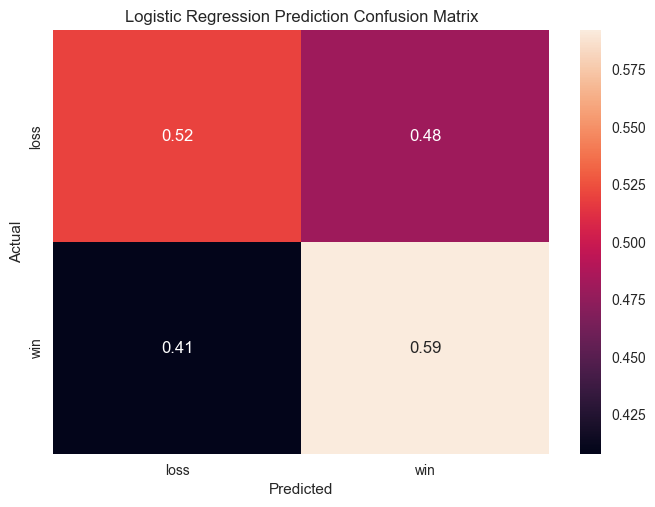

In [272]:
conf_mat = confusion_matrix(y_test_labeled, 
                            LR_predictions_labeled, 
                            normalize='true')

sns.heatmap(conf_mat, 
            annot=True,
            xticklabels=labels, 
            yticklabels=labels, )
plt.title('Logistic Regression Prediction Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Predict Validation Season

In [273]:
predictions_2023 = LR_fit.predict(validation_season_x)
probabilites_2023 = LR_fit.predict_proba(validation_season_x)
win_probabilities_2023 = probabilites_2023[:, 1]

In [274]:
validation_season['predicted_result'] = predictions_2023
validation_season['prediction_confidence'] = win_probabilities_2023
output = validation_season.loc[:,['game_id', 'season', 'week' , 'team', 'home_away', 'spread_line', 
                              'points_scored', 'points_allowed', 'favored', 'result', 
                              'predicted_result', 'prediction_confidence']]

/var/folders/xs/9jzktm9106l0bx0xw3ppdtfw0000gn/T/ipykernel_81817/3702005309.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_season['predicted_result'] = predictions_2023
/var/folders/xs/9jzktm9106l0bx0xw3ppdtfw0000gn/T/ipykernel_81817/3702005309.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_season['prediction_confidence'] = win_probabilities_2023


In [276]:
output.sort_values(by=['season', 'week', 'team'])

,game_id,season,week,team,home_away,spread_line,points_scored,points_allowed,favored,result,predicted_result,prediction_confidence
1523,2023_03_DAL_ARI,2023,3,ARI,home,-11.5,28,16,0,1,0,0.371617
1524,2023_03_LA_CIN,2023,3,CIN,home,3.0,19,16,1,1,0,0.444454
1525,2023_03_TEN_CLE,2023,3,CLE,home,3.5,27,3,1,1,1,0.504243
1526,2023_03_DEN_MIA,2023,3,DEN,away,6.0,20,70,0,0,1,0.553485
1527,2023_03_ATL_DET,2023,3,DET,home,3.0,20,6,1,1,1,0.595245
1528,2023_03_HOU_JAX,2023,3,JAX,home,7.5,17,37,1,0,1,0.503638
1529,2023_03_CHI_KC,2023,3,KC,home,13.0,41,10,1,1,1,0.595878
1530,2023_03_LAC_MIN,2023,3,MIN,home,1.0,24,28,1,0,1,0.513481
1531,2023_03_NE_NYJ,2023,3,NE,away,-2.5,15,10,1,1,0,0.480866
1532,2023_03_NO_GB,2023,3,NO,away,-1.5,17,18,1,0,1,0.517407
